In [ ]:
import os,sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import CPS

In [ ]:
opt = CPS.config()
args = opt.parse_args(['--seed', '2025'])
args.prep_scale = True
args.dataset_path = '/mnt/d/Dataset/SRT_Dataset/MOSTA'
args.max_neighbors=8
args.hvgs=2000
args.er_w=5.
args.max_epoch=20
args.sigma=1
args.freq=32
CPS.set_random_seed(args.seed)
args.k_list = [0,1,2,3,4,5,6,7]
args

In [4]:
adata = sc.read_h5ad(args.dataset_path + '/E14.5_E1S1.MOSTA.h5ad')
adata

AnnData object with n_obs × n_vars = 102519 × 28463
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - Alx1', 'Regulon - Alx3', 'Regulon - Alx4', 'Regulon - Arid3a', 'Regulon - Arnt', 'Regulon - Arnt2', 'Regulon - Arx', 'Regulon - Ascl2', 'Regulon - Atf1', 'Regulon - Atf2', 'Regulon - Atf3', 'Regulon - Atf4', 'Regulon - Atf5', 'Regulon - Atf6', 'Regulon - Atf6b', 'Regulon - Barhl1', 'Regulon - Barhl2', 'Regulon - Barx1', 'Regulon - Bcl11a', 'Regulon - Bcl3', 'Regulon - Bclaf1', 'Regulon - Bdp1', 'Regulon - Bhlha15', 'Regulon - Bhlhe22', 'Regulon - Bhlhe40', 'Regulon - Bmyc', 'Regulon - Borcs8', 'Regulon - Bptf', 'Regulon - Brca1', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Bsx', 'Regulon - Cdx1', 'Regulon - Cdx2', 'Regulon - Cebpa', 'Regulon - Cebpb', 'Regulon - Cebpe', 'Regulon - Cebpg', 'Regulon - Cebpz', 'Regulon - Cnot3', 'Regulon - Creb1', 'Regulon - Creb3', 'Regulon - Creb3l1', 'Regulon - Creb3l2', 'Regulon 

In [5]:
adata.obs['annotation']

cell_name
204_258    Cavity
204_259    Cavity
204_260    Cavity
204_261    Cavity
204_262    Cavity
            ...  
659_299    Cavity
659_300    Cavity
659_301    Cavity
659_302    Cavity
659_303    Cavity
Name: annotation, Length: 102519, dtype: category
Categories (26, object): ['Adipose tissue', 'Adrenal gland', 'Brain', 'Cartilage', ..., 'Pancreas', 'Smooth muscle', 'Spinal cord', 'Thymus']

In [6]:
adata.var_names_make_unique()
adata.layers["counts"] = adata.X.copy()
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=args.hvgs)
adata_hvg = adata[:, adata.var['highly_variable']].copy()
sc.pp.normalize_total(adata_hvg, target_sum=1e4)
sc.pp.log1p(adata_hvg)
sc.pp.scale(adata_hvg, zero_center=True)

counts_layer = adata_hvg.layers['counts']
adata_hvg.obsm['hvg_features'] = adata_hvg.X
adata_hvg.obsm['hvg_counts'] = counts_layer.toarray()

In [7]:
spatial_edge = CPS.SpatialGraphBuilder(args)
pyg_data = spatial_edge.build_large_graph(adata_hvg, method='knn')
print(pyg_data.num_nodes, pyg_data.num_genes, pyg_data.edge_index.shape)

102519 2000 torch.Size([2, 926175])


In [8]:
from CPS.module import MultiHopSGConv
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
import torch
tokenizer = MultiHopSGConv(k_list=args.k_list, prep_scale=True)
input_feat = pyg_data.x.cpu().numpy()
svd = TruncatedSVD(n_components=64, algorithm='randomized', random_state=42)
x_reduced = svd.fit_transform(input_feat)
scaler = StandardScaler()
x_reduced = scaler.fit_transform(x_reduced)
pyg_data.x = torch.from_numpy(x_reduced).float()
tokens = tokenizer(pyg_data.x, pyg_data.edge_index)
pyg_data.x = tokens

In [9]:
import time
start_time = time.time()
cps_model = CPS.CPSTrainer(args, input_dim=64)
cps_model.efficient_fit(pyg_data, print_every=2)

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch   0: Train[Total:1.7310, T:1.2218, S:0.2850, D:0.2242]

Epoch   2: Train[Total:0.5443, T:0.2650, S:0.2689, D:0.0104]

Epoch   4: Train[Total:0.5258, T:0.2599, S:0.2644, D:0.0015]

Epoch   6: Train[Total:0.5199, T:0.2574, S:0.2618, D:0.0007]

Epoch   8: Train[Total:0.5171, T:0.2562, S:0.2604, D:0.0005]

Epoch  10: Train[Total:0.5154, T:0.2554, S:0.2596, D:0.0004]

Epoch  12: Train[Total:0.5152, T:0.2556, S:0.2593, D:0.0003]

Epoch  14: Train[Total:0.5143, T:0.2551, S:0.2590, D:0.0003]

Epoch  16: Train[Total:0.5139, T:0.2548, S:0.2588, D:0.0003]

Epoch  18: Train[Total:0.5144, T:0.2554, S:0.2588, D:0.0002]

Epoch  19: Train[Total:0.5138, T:0.2550, S:0.2586, D:0.0002]


In [10]:
end_time = time.time()
print(f"time: {end_time - start_time:.4f} s")

time: 89.3597 s


In [11]:
z_s, latent, attn = cps_model.interpret_attn_scores(pyg_data)
adata_hvg.obsm['z_s'] = z_s
adata_hvg.obsm['z_t'] = latent
adata_hvg.obsm['attns'] = attn
adata_hvg.obsm['attn'] = attn.reshape(adata_hvg.n_obs, 32)

In [12]:
adata_hvg

AnnData object with n_obs × n_vars = 102519 × 2000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - Alx1', 'Regulon - Alx3', 'Regulon - Alx4', 'Regulon - Arid3a', 'Regulon - Arnt', 'Regulon - Arnt2', 'Regulon - Arx', 'Regulon - Ascl2', 'Regulon - Atf1', 'Regulon - Atf2', 'Regulon - Atf3', 'Regulon - Atf4', 'Regulon - Atf5', 'Regulon - Atf6', 'Regulon - Atf6b', 'Regulon - Barhl1', 'Regulon - Barhl2', 'Regulon - Barx1', 'Regulon - Bcl11a', 'Regulon - Bcl3', 'Regulon - Bclaf1', 'Regulon - Bdp1', 'Regulon - Bhlha15', 'Regulon - Bhlhe22', 'Regulon - Bhlhe40', 'Regulon - Bmyc', 'Regulon - Borcs8', 'Regulon - Bptf', 'Regulon - Brca1', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Bsx', 'Regulon - Cdx1', 'Regulon - Cdx2', 'Regulon - Cebpa', 'Regulon - Cebpb', 'Regulon - Cebpe', 'Regulon - Cebpg', 'Regulon - Cebpz', 'Regulon - Cnot3', 'Regulon - Creb1', 'Regulon - Creb3', 'Regulon - Creb3l1', 'Regulon - Creb3l2', 'Regulon -

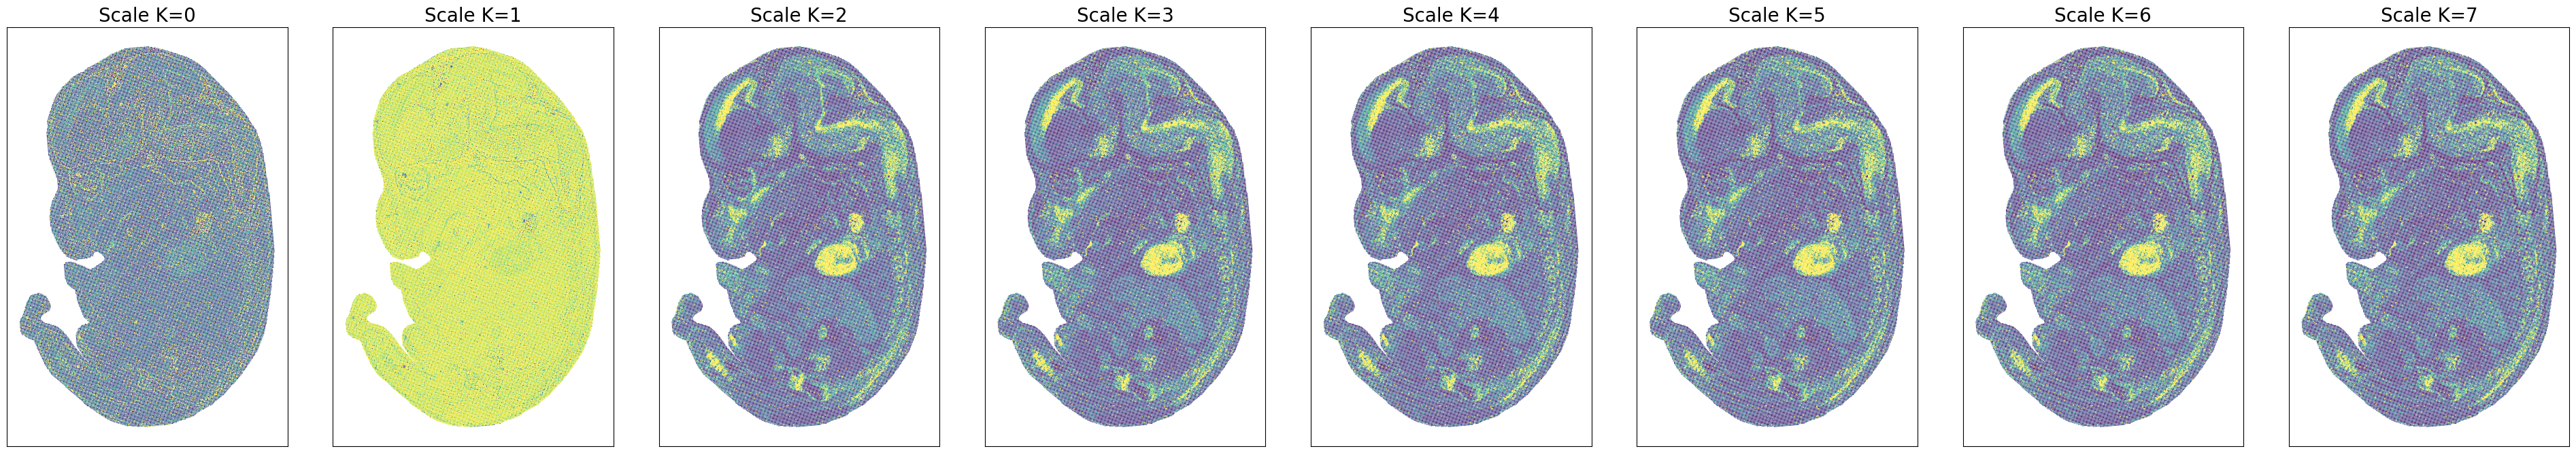

In [13]:
# show the average attention scores of multiple scales
attn_avg_heads = attn.mean(axis=-1)
for i, k in enumerate(args.k_list):
    adata_hvg.obs[f'Scale K={k}'] = attn_avg_heads[:, i]

context_params = {
    'figure.figsize': (6, 8),
    'font.size': 12,             
    'axes.titlesize': 20,        
    'legend.fontsize': 10,      
    'axes.labelsize': 12,        
    'xtick.labelsize': 10,        
    'ytick.labelsize': 10,
}

with plt.rc_context(context_params):
    axes_list = sc.pl.spatial(
        adata_hvg, 
        color=[f'Scale K={k}' for k in args.k_list],
        show=False,
        spot_size=1,
        colorbar_loc=None,
        cmap='viridis',
        ncols=8,
        vmax='p95',
        wspace=0.0, 
    )

    if not isinstance(axes_list, list):
        axes_list = [axes_list]
    for ax in axes_list:
        ax.set_xlabel('')  
        ax.set_ylabel('')  
    plt.subplots_adjust(wspace=1, hspace=0.2)
    
    plt.show()

In [14]:
args.clusters=26
adata_hvg = CPS.mclust(adata_hvg, args, key='z_s', pca_dim=32)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


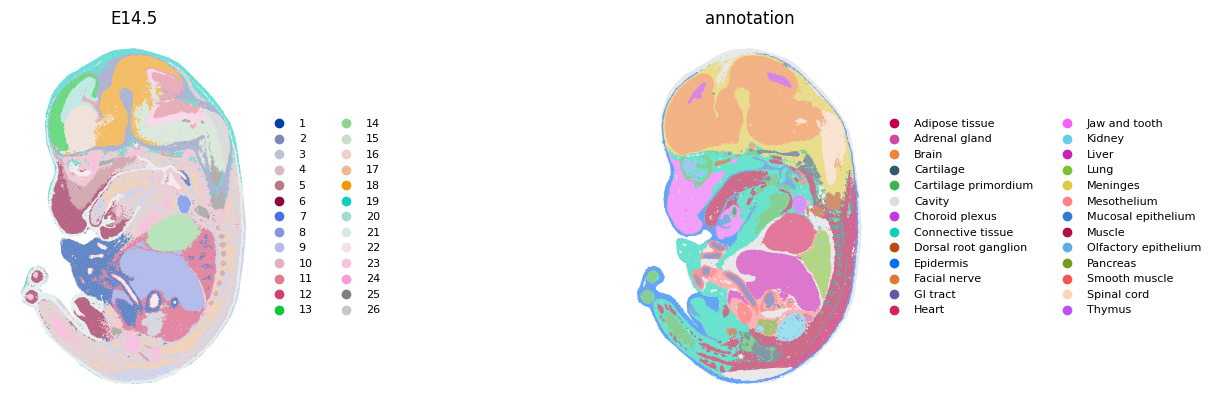

In [15]:
sc.pl.spatial(adata_hvg, img_key=None, color=['mclust','annotation'], 
              title=['E14.5'], size=1., legend_fontsize=8, 
              frameon=False, spot_size=1)